## Rules and noisy data used for behaviour cloning teacher

## Use noisy states from buffer to BC teacher

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import numpy as np
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [49]:
class Actor(nn.Module):

    def __init__(self, num_state, num_actions, seed):
        super(Actor, self).__init__()

        # set seed
        torch.manual_seed(seed)

        num_hidden = 256

        self.fnn = nn.Sequential(
            nn.Linear(in_features=num_state, out_features=num_hidden),
            nn.SELU(),
            nn.Linear(in_features=num_hidden, out_features=num_hidden),
            nn.SELU(),
            nn.Linear(in_features=num_hidden, out_features=num_hidden),
            nn.SELU(),
            nn.Linear(in_features=num_hidden, out_features=num_actions)
        )

        for param in self.parameters():
            if len(param.shape) == 1:
                torch.nn.init.constant_(param, 0)
            if len(param.shape) >= 2:
                torch.nn.init.kaiming_normal_(param, mode='fan_in', nonlinearity='linear')

    def forward(self, state):
        if len(state.shape) == 1:
            state = state.unsqueeze(dim=0)

        return self.fnn(state)

In [50]:
# Function to collect expert demonstrations actions
def collect_demonstrations(data):
    observations = []
    actions = []

    for i in range(len(data)):
        action = expert_policy(data[i])
        if(action == None):
            print(data[i])
        observations.append(data[i])
        actions.append(action)

    return np.array(observations), np.array(actions)

In [66]:
# Training the behavior cloning model
# 256 1e-3 for other environments
def train_behavior_cloning(model, observations, actions, num_epochs=100, batch_size=128, learning_rate=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # Shuffle data
        indices = np.arange(len(observations))
        np.random.shuffle(indices)

        for start in range(0, len(observations), batch_size):
            end = start + batch_size
            batch_indices = indices[start:end]

            # Convert data to PyTorch tensors
            obs_batch = torch.FloatTensor(observations[batch_indices])
            #print(observations[batch_indices])
            #print(actions[batch_indices])
            action_batch = torch.LongTensor(actions[batch_indices])

            # Forward pass
            logits = model(obs_batch)
            #print(logits)
            #print(action_batch)

            # Compute loss
            loss = criterion(logits, action_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            evaluate()
            print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

## BC Mountain car

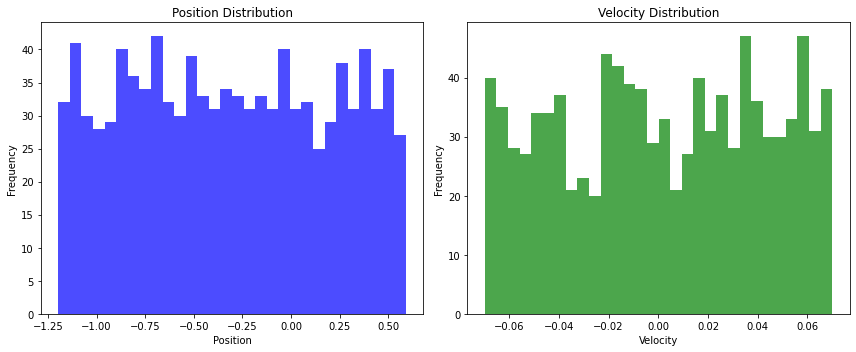

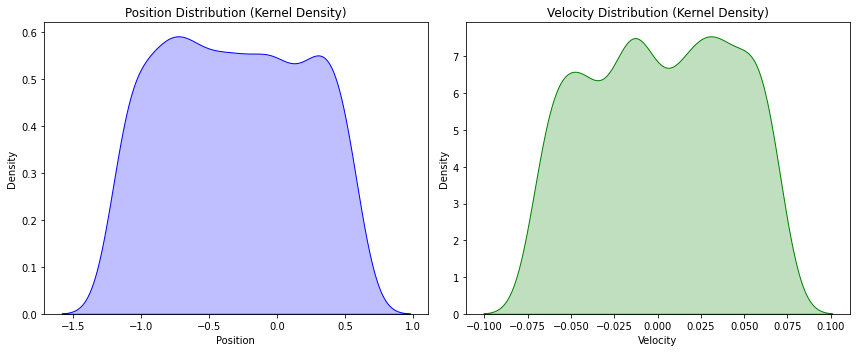

In [13]:
# Define the bounds for position and velocity
df = pd.read_pickle('data/MountainCar-v0_run3_randomconv.pkl')

# Define the bounds for position and velocity
position_bounds = [0.6, -1.2]
velocity_bounds = [0.07, -0.07]

# Number of data points
num_points = 1000

# Generate random values within the specified bounds
positions = np.random.uniform(position_bounds[1], position_bounds[0], num_points)
velocities = np.random.uniform(velocity_bounds[1], velocity_bounds[0], num_points)
data = []

# Number of data points
num_points = 10000

# Generate random values within the specified bounds
position = []
velocity = []
for ind in df.index:
    position.append(df['state'][ind][0])
    velocity.append(df['state'][ind][1])
    data.append(df['state'][ind])
    # action_full.append(df['action'][ind][0])

# Create 2D histograms
plt.figure(figsize=(12, 5))

# Plotting position histogram
plt.subplot(1, 2, 1)
plt.hist(positions, bins=30, color='blue', alpha=0.7)
plt.title('Position Distribution')
plt.xlabel('Position')
plt.ylabel('Frequency')

# Plotting velocity histogram
plt.subplot(1, 2, 2)
plt.hist(velocities, bins=30, color='green', alpha=0.7)
plt.title('Velocity Distribution')
plt.xlabel('Velocity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Create 2D kernel density plots
plt.figure(figsize=(12, 5))

# Plotting position kernel density
plt.subplot(1, 2, 1)
sns.kdeplot(positions, color='blue', fill=True)
plt.title('Position Distribution (Kernel Density)')
plt.xlabel('Position')
plt.ylabel('Density')

# Plotting velocity kernel density
plt.subplot(1, 2, 2)
sns.kdeplot(velocities, color='green', fill=True)
plt.title('Velocity Distribution (Kernel Density)')
plt.xlabel('Velocity')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [9]:
class MActor(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 hidden_dims=(32, 32),
                 activation_fc=F.relu):
        super(MActor, self).__init__()
        self.activation_fc = activation_fc
        self.dropout = nn.Dropout(p=0.5)
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x,
                             device=self.device,
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, state, training=True):
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        if not training:
            x = self.dropout(x)
        x = self.output_layer(x)
        return F.softmax(x)

/home/ubuntu/anaconda3/envs/sonyenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
anetwork_local = MActor(2, 3, hidden_dims=(128,128))
anetwork_local.load_state_dict(torch.load('mountaincar.pth'))

<All keys matched successfully>

In [ ]:
def get_action_heur(observation):
    state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
    qnetwork_local.eval()
    with torch.no_grad():
        action_values = qnetwork_local(state)
    return np.argmax(action_values.cpu().data.numpy())

In [6]:
# Expert policy (target policy in this case)
def expert_policy(observation):
    # Replace this with your expert policy logic
    action = random.randint(0, 2)
    position = observation[0]
    velocity = observation[1]
    if position < -0.5:
        if velocity < -0.01:
            action = 0
        else:
            action = 2
    else:
        if velocity > 0.01:
            action = 2
    return action

In [15]:
if __name__ == "__main__":
    
    env = gym.make("MountainCar-v0")

    # Collect expert demonstrations
    expert_observations, expert_actions = collect_demonstrations(data)

    # Define the behavior cloning model
    input_size = expert_observations.shape[1]
    output_size = env.action_space.n  # Assuming discrete action space
    model = Actor(input_size, output_size,0)

    # Train the behavior cloning model
    train_behavior_cloning(model, expert_observations, expert_actions)

Epoch 0/100, Loss: 0.41382700204849243
Epoch 10/100, Loss: 0.28489401936531067
Epoch 20/100, Loss: 0.2801625430583954
Epoch 30/100, Loss: 0.30062946677207947
Epoch 40/100, Loss: 0.2627647817134857
Epoch 50/100, Loss: 0.2962140142917633
Epoch 60/100, Loss: 0.24094609916210175
Epoch 70/100, Loss: 0.23463746905326843
Epoch 80/100, Loss: 0.23508505523204803
Epoch 90/100, Loss: 0.2575281262397766


In [17]:
# Evaluate the trained model
env = gym.make("MountainCar-v0")
total_reward = 0
num_episodes = 100
buffer_heur = []
buffer_other = []
for _ in range(num_episodes):
    obs = env.reset()
    done = False
    ep_rew = 0

    while not done:
        # action = model(torch.FloatTensor(obs)).argmax().item()
        action = expert_policy(obs)
        obs, reward, done, _ = env.step(action)
        total_reward += reward
        ep_rew += reward
    print(ep_rew)

avg_reward = total_reward / num_episodes
print(f'Average reward over {num_episodes} episodes: {avg_reward}')

env.close()

-91.0
-200.0
-119.0
-200.0
-200.0
-200.0
-200.0
-100.0
-145.0
-200.0
-157.0
-121.0
-200.0
-120.0
-116.0
-200.0
-200.0
-149.0
-200.0
-124.0
-200.0
-200.0
-119.0
-174.0
-124.0
-176.0
-120.0
-149.0
-125.0
-200.0
-200.0
-200.0
-200.0
-108.0
-200.0
-121.0
-146.0
-169.0
-113.0
-200.0
-200.0
-121.0
-122.0
-186.0
-118.0
-119.0
-200.0
-123.0
-104.0
-200.0
-124.0
-106.0
-121.0
-137.0
-118.0
-200.0
-200.0
-118.0
-119.0
-104.0
-119.0
-200.0
-200.0
-119.0
-124.0
-200.0
-193.0
-120.0
-200.0
-200.0
-200.0
-200.0
-200.0
-200.0
-122.0
-200.0
-200.0
-119.0
-122.0
-200.0
-122.0
-120.0
-99.0
-200.0
-119.0
-200.0
-123.0
-200.0
-200.0
-200.0
-200.0
-118.0
-132.0
-102.0
-118.0
-200.0
-200.0
-120.0
-133.0
-97.0
Average reward over 100 episodes: -157.67


In [41]:
torch.save(model.state_dict(), 'mountaincarabc.pt')

In [44]:
anetwork_local = Actor(2, 3, 0)
anetwork_local.load_state_dict(torch.load('mountaincarabc.pt'))

<All keys matched successfully>

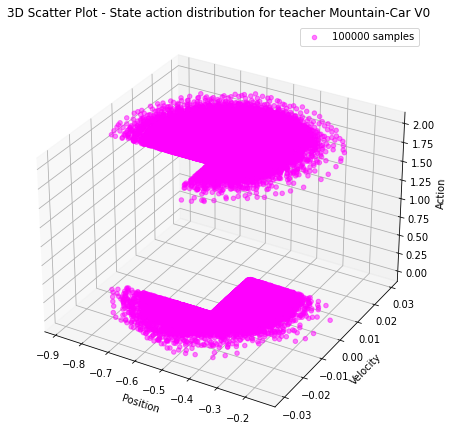

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create 3D scatter plots for position and velocity for full dataset, first 10,000, and sampled data
fig = plt.figure(figsize=(18, 6))

# Plot for full dataset
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter(position, velocity, expert_actions, c='magenta', label='100000 samples', alpha=0.5)
ax1.set_xlabel('Position')
ax1.set_ylabel('Velocity')
ax1.set_zlabel('Action')
ax1.set_title('3D Scatter Plot - State action distribution for teacher Mountain-Car V0')
ax1.legend()

plt.tight_layout()
plt.show()

## Cartpole BC from random data

In [21]:
# Define the bounds for position and velocity
df = pd.read_pickle('OfflineRL-OOD-Teacher-Student/Discrete/CQL-DQN/data/CartPole-v1_run3_randomconv.pkl')

/home/ubuntu/anaconda3/envs/sonyenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
# Expert policy (target policy in this case)
def expert_policy(observation):
    action = random.choice([0, 1])
    if observation[0] > -1:
        if observation[0] < 1:
            if observation[2] < 0:
                action = 0
            else:
                action = 1
        else:
            if observation[2] < 0:
                action = 0
            else:
                if observation[1] > 0:
                    if observation[3] < 0:
                        action = 0
                    else:
                        action = 1
                else:
                    if observation[2] < 0:
                        action = 0
                    else:
                        action = 1
    else:
        if observation[2] < 0:
            if observation[1] < 0:
                if observation[3] > 0:
                    action = 1
                else:
                    action = 0
            else:
                if observation[2] < 0:
                    action = 0
                else:
                    action = 1
    return action

In [71]:
if __name__ == "__main__":
    data = []
    for ind in df.index:
        data.append(df['state'][ind])
    
    env = gym.make("CartPole-v1")

    # Collect expert demonstrations
    expert_observations, expert_actions = collect_demonstrations(data)

    # Define the behavior cloning model
    input_size = expert_observations.shape[1]
    output_size = env.action_space.n  # Assuming discrete action space
    model = Actor(input_size, output_size,0)

    # Train the behavior cloning model
    train_behavior_cloning(model, expert_observations, expert_actions)

Epoch 0/100, Loss: 0.008418798446655273
Epoch 10/100, Loss: 0.004097086377441883
Epoch 20/100, Loss: 0.0019288783660158515
Epoch 30/100, Loss: 0.004586287774145603
Epoch 40/100, Loss: 0.011334984563291073
Epoch 50/100, Loss: 0.007198832929134369
Epoch 60/100, Loss: 1.8051021470455453e-05
Epoch 70/100, Loss: 2.0471006791922264e-05
Epoch 80/100, Loss: 0.0023348848335444927
Epoch 90/100, Loss: 4.999142788619793e-07


In [72]:
# Evaluate the trained model
env = gym.make("CartPole-v1")
total_reward = 0
num_episodes = 10
buffer_heur = []
buffer_other = []
for _ in range(num_episodes):
    obs = env.reset()
    done = False
    ep_rew = 0

    while not done:
        action = model(torch.FloatTensor(obs)).argmax().item()
        # action = expert_policy(obs)
        obs, reward, done, _ = env.step(action)
        total_reward += reward
        ep_rew += reward
    print(ep_rew)

avg_reward = total_reward / num_episodes
print(f'Average reward over {num_episodes} episodes: {avg_reward}')

env.close()

31.0
46.0
43.0
38.0
54.0
36.0
35.0
41.0
35.0
50.0
Average reward over 10 episodes: 40.9


In [73]:
torch.save(model.state_dict(), 'cartpoleabc44.pt')

In [48]:
anetwork_local = Actor(4, 2, 0)
anetwork_local.load_state_dict(torch.load('cartpoleabc44.pt'))

<All keys matched successfully>

## Lunar Lander

In [9]:
# Define the bounds for position and velocity
df = pd.read_pickle('data/LunarLander-v2_run3_randomconv.pkl')

In [95]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        # self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return F.softmax(self.fc3(x))

In [96]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
qnetwork_local = QNetwork(8, 4, 0).to(device)
qnetwork_local.load_state_dict(torch.load('model/checkpoint30.pth'))

<All keys matched successfully>

In [97]:
def get_action_heur(observation):
    state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
    qnetwork_local.eval()
    with torch.no_grad():
        action_values = qnetwork_local(state)
    return np.argmax(action_values.cpu().data.numpy())

In [64]:
# Expert policy (target policy in this case)
def expert_policy(obs):
    # Replace this with your expert policy logic
    action = random.randint(0, 3)
    if obs[5]<0.04:
        if obs[3]> -0.35:
            action = get_action_heur(obs)
        else:
            if obs[5]>-0.22:
                action = get_action_heur(obs)
            else:
                if obs[4]>-0.04:
                    action = get_action_heur(obs)
    return action

In [87]:
if __name__ == "__main__":
    data = []
    for ind in df.index:
        data.append(df['state'][ind])
    
    env = gym.make("LunarLander-v2")

    # Collect expert demonstrations
    expert_observations, expert_actions = collect_demonstrations(data)
    #print(expert_actions[0:100])

    # Define the behavior cloning model
    input_size = expert_observations.shape[1]
    output_size = env.action_space.n  # Assuming discrete action space
    model = Actor(input_size, output_size,0)

    # Train the behavior cloning model
    train_behavior_cloning(model, expert_observations, expert_actions)

/home/ubuntu/anaconda3/envs/sonyenv/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0/100, Loss: 0.5901600122451782
Epoch 10/100, Loss: 0.44198083877563477
Epoch 20/100, Loss: 0.47865375876426697
Epoch 30/100, Loss: 0.48859214782714844
Epoch 40/100, Loss: 0.3983001708984375
Epoch 50/100, Loss: 0.45174941420555115
Epoch 60/100, Loss: 0.4957652986049652
Epoch 70/100, Loss: 0.50995272397995
Epoch 80/100, Loss: 0.4589824676513672
Epoch 90/100, Loss: 0.4217764437198639


In [94]:
# Evaluate the trained model
env = gym.make("LunarLander-v2")
total_reward = 0
num_episodes = 10
buffer_heur = []
buffer_other = []
for _ in range(num_episodes):
    obs = env.reset()
    done = False
    ep_rew = 0

    while not done:
        action = model(torch.FloatTensor(obs)).argmax().item()
        # action = expert_policy(obs)
        obs, reward, done, _ = env.step(action)
        total_reward += reward
        ep_rew += reward
    print(ep_rew)

avg_reward = total_reward / num_episodes
print(f'Average reward over {num_episodes} episodes: {avg_reward}')

env.close()

166.3451475411211
292.31847446273827
14.422953887745948
65.36275026557651
-70.23115241207947
-118.42030809301681
26.06097281708979
-82.99129510246469
22.638832535471273
209.37634072630402
Average reward over 10 episodes: 52.48827166284834


In [70]:
torch.save(model.state_dict(), 'checkpoint30.pt')

## Minigrid Lavagaps 

In [10]:
from gym import spaces
import random, numpy, argparse
class FlatImgObsWrapper(gym.core.ObservationWrapper):
    """
    Use the image as the only observation output, no language/mission and flatten it
    Modified from https://github.com/maximecb/gym-minigrid/blob/master/gym_minigrid/wrappers.py
    to not only remove mission string but also remove the third dimension(representing the door state that can be open,
    closed or locked) which is unnecessary as I am not using doors and flatten from 7x7x2 to 98.
    """

    def __init__(self, env):
        super().__init__(env)
        obs_shape = env.observation_space.spaces['image'].shape

        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(obs_shape[0] * obs_shape[1] * 2,),
            dtype='uint8'
        )

    def observation(self, obs):
        # division by 10 as the first dimension can hold up to 5 different colors
        # and the second channel can hold up to 10 different objects
        # return obs['image'][:, :, :1], obs['direction']
        return obs['image'][:, :, :2].flatten() / 10, # obs['direction']


class RestrictMiniGridActionWrapper(gym.core.ActionWrapper):
    """
    restrict to the first three actions -> turn left, turn right and move forward.
    This is sufficient for the used environments from MiniGrid
    """

    def __init__(self, env):
        super(RestrictMiniGridActionWrapper, self).__init__(env)
        self.action_space = gym.spaces.Discrete(3)

    def action(self, action):
        return action
class SymbolicObsWrapper(gym.core.ObservationWrapper):
    """
    Use the image as the only observation output, no language/mission and flatten it
    Modified from https://github.com/maximecb/gym-minigrid/blob/master/gym_minigrid/wrappers.py
    to not only remove mission string but also remove the third dimension(representing the door state that can be open,
    closed or locked) which is unnecessary as I am not using doors and flatten from 7x7x2 to 98.
    """
    # Map of object type to integers
    OBJECT_TO_IDX = {
        "unseen": 0,
        "empty": 1,
        "wall": 2,
        "floor": 3,
        "door": 4,
        "key": 5,
        "ball": 6,
        "box": 7,
        "goal": 8,
        "lava": 9,
        "agent": 10,
    }

    def __init__(self, env):
        super().__init__(env)
        obs_shape = env.observation_space.spaces['image'].shape

        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(obs_shape[0] * obs_shape[1] * 2,),
            dtype='uint8'
        )

    def observation(self, obs):
        def observation(self, obs):
            objects = np.array(
                [OBJECT_TO_IDX[o.type] if o is not None else -1 for o in self.grid.grid]
            )
            print(objects)
            agent_pos = self.env.agent_pos
            ncol, nrow = self.width, self.height
            grid = np.mgrid[:ncol, :nrow]
            _objects = np.transpose(objects.reshape(1, nrow, ncol), (0, 2, 1))

            grid = np.concatenate([grid, _objects])
            grid = np.transpose(grid, (1, 2, 0))
            grid[agent_pos[0], agent_pos[1], 2] = OBJECT_TO_IDX["agent"]
            obs["image"] = grid
            return obs

In [114]:
# Define the bounds for position and velocity
df = pd.read_pickle('data/MiniGrid-LavaGapS7-v0_run3_randomconv.pkl')

In [79]:
def expert_policy1(state):
    obs = state
    # choose one action at random 
    action = random.randint(0, 2)
    # wall or lava in the left side 
    if(obs[40] == 0.2 or obs[40] == 0.9):
        #print('-------left-------')
        # do not choose turn left
        action = random.choice([1, 2])
    # wall or lava in the right side 
    if(obs[68] == 0.2 or obs[68] == 0.9):
        # do not choose turn right
        #print('-------right-------')
        action = random.choice([0, 2])
    # wall or lava in front
    if(obs[52] == 0.2 or obs[52] == 0.9):
        #print('-------forward-------')
        # do not choose move forward
        action = random.choice([1, 0])
    # handling wall and lava on left and front
    if(obs[40] == (0.2 or 0.9)  and obs[52] == (0.2 or 0.9)):
        #print('-------left-------')
        # choose turn right
        action = 1
    # handling wall and lava on left and right
    '''if(obs[40] == (0.2 or 0.9)  and obs[68] == (0.2 or 0.9)):
        #print('-------left-------')
        # choose forward
        action = 2
    # handling wall and lava on right and forward
    if(obs[68] == (0.2 or 0.9)  and obs[52] == (0.2 or 0.9)):
        #print('-------left-------')
        # choose left
        action = 0'''
    return action

In [115]:
def expert_policy(state):
    obs = state
    action = 2
    # Wall or lava in front
    if obs[52] == 0.9 or obs [52] == [0.2]:
        # Wall or lava not in left move left
        if obs[40] not in [0.2, 0.9]:
            action = 0
        # Wall or lava not in right move right
        elif obs[68] not in [0.2, 0.9]:
            action = 1
        else:
            action = random.choice([0, 1])
    return action

/home/ubuntu/anaconda3/envs/sonyenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [116]:
if __name__ == "__main__":
    data = []
    action = []
    for ind in df.index:
        data.append(df['state'][ind])
        action.append(df['action'][ind][0])
    
    env = gym.make("MiniGrid-LavaGapS7-v0")
    env = FlatImgObsWrapper(RestrictMiniGridActionWrapper(env))

    # Collect expert demonstrations
    print(len(data[0]))
    #expert_observations = np.array(data)
    # print(expert_observations[0])
    #expert_actions = np.array(action)
    # print(expert_actions[0:100])
    expert_observations, expert_actions = collect_demonstrations(data)
    # print(type(expert_observations))
    # print(expert_actions[0:100])

    # Define the behavior cloning model
    input_size = 98 #expert_observations.shape[1]
    # print(input_size)
    output_size = env.action_space.n  # Assuming discrete action space
    model = Actor(input_size, output_size,0)

    # Train the behavior cloning model
    train_behavior_cloning(model, expert_observations, expert_actions)

98
0
0
0
0
0.9540816326530612
0
0
0
0.9540816326530612
0
Average reward over 10 episodes: 0.19081632653061226
Epoch 0/100, Loss: 0.00010729704808909446
0.9586734693877551
0.9540816326530612
0.9540816326530612
0
0
0
0
0.9586734693877551
0
0
Average reward over 10 episodes: 0.38255102040816324
Epoch 10/100, Loss: 1.6018745441215287e-07
0.9586734693877551
0
0
0.9586734693877551
0
0
0.9586734693877551
0.9586734693877551
0
0.9540816326530612
Average reward over 10 episodes: 0.4788775510204082
Epoch 20/100, Loss: 0.0
0.9586734693877551
0
0.9540816326530612
0
0.9540816326530612
0.9540816326530612
0.9540816326530612
0
0.9540816326530612
0.9540816326530612
Average reward over 10 episodes: 0.6683163265306121
Epoch 30/100, Loss: 0.0
0.9586734693877551
0.9586734693877551
0.9540816326530612
0.9540816326530612
0.9586734693877551
0
0.9586734693877551
0
0.9540816326530612
0.9540816326530612
Average reward over 10 episodes: 0.7651020408163266
Epoch 40/100, Loss: 0.0
0
0
0.9586734693877551
0.95867346938

In [107]:
# Evaluate the trained model
def evaluate():
    env = gym.make("MiniGrid-LavaGapS7-v0")
    env = FlatImgObsWrapper(RestrictMiniGridActionWrapper(env))
    total_reward = 0
    num_episodes = 10
    buffer_heur = []
    buffer_other = []
    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        ep_rew = 0

        while not done:
            action = model(torch.FloatTensor(obs[0])).argmax().item()
            #action = expert_policy2(obs[0])
            obs, reward, done, _ = env.step(action)
            total_reward += reward
            ep_rew += reward
        print(ep_rew)

    avg_reward = total_reward / num_episodes
    print(f'Average reward over {num_episodes} episodes: {avg_reward}')

    env.close()

In [110]:
evaluate()

0.9540816326530612
0
0
0
0.9586734693877551
0.9540816326530612
0
0.9540816326530612
0
0
Average reward over 10 episodes: 0.3820918367346938
